# Novelty Function

### References
Text book: [Sect. 9.3.1](https://ieeexplore.ieee.org/document/9966202/) 

Slides: [09-03-ACA-Temporal-Onsets.pdf](https://github.com/alexanderlerch/ACA-Slides/blob/2nd_edition/09-03-ACA-Temporal-Onsets.pdf)

#### Summary:
A Novelty Function measures the probability of new events or signal changes occurring over `time`. Also known as a detection function or difference function, it can be categorized into three domains: `time domain`, `pitch domain`, and `STFT-based`.


#### How it usually works:
(For a detailed implementation of these steps, we can examine the [`computeNoveltyFunction`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/computeNoveltyFunction.py#L32) source code)
1. Feature extraction
2. Deveriation computation
3. Result Smoothing
4. Half-Wave-Rectification
5. Find local maxima above the threshold




---
### Time Domain Novelty Function:


In [21]:
# an example of time domain novelty function:
import numpy as np
import math
from scipy.signal import filtfilt
from scipy.signal import find_peaks

def computeEnergyNovelty(wav, frame_size, hop_size, f_s):
    # Calculate the number of frames
    num_frames = 1 + (len(wav) - frame_size) // hop_size
    energy = np.zeros(num_frames)
    t = np.arange(0, len(wav) / f_s, hop_size / f_s)[:num_frames]
    # Compute energy for each frame
    for i in range(num_frames):
        start = i * hop_size
        frame = wav[start:start+frame_size]
        energy[i] = np.sum(frame ** 2)
    
    # Compute novelty function as the positive difference between adjacent energy values
    d = np.diff(energy, prepend=energy[0])
    
    fLenSmoothLpInS = 0.07
    fLenThreshLpInS = 0.14
    iLenSmoothLp = np.max([2, math.ceil(fLenSmoothLpInS * f_s / hop_size)])
    iLenThreshLp = np.max([2, math.ceil(fLenThreshLpInS * f_s / hop_size)])

    b = np.ones(iLenSmoothLp) / iLenSmoothLp
    d = filtfilt(b, 1, d)
    d[d < 0] = 0

    # compute threshold
    iLenThreshLp = min(iLenThreshLp, np.floor(len(d)/3))
    b = np.ones(iLenThreshLp) / iLenThreshLp
    G_T = .4 * np.mean(d[np.arange(1, d.shape[0])]) + filtfilt(b, 1, d)

    # find local maxima above the threshold
    iPeaks = find_peaks(d - G_T, height=0)

    return d, t, iPeaks[0]

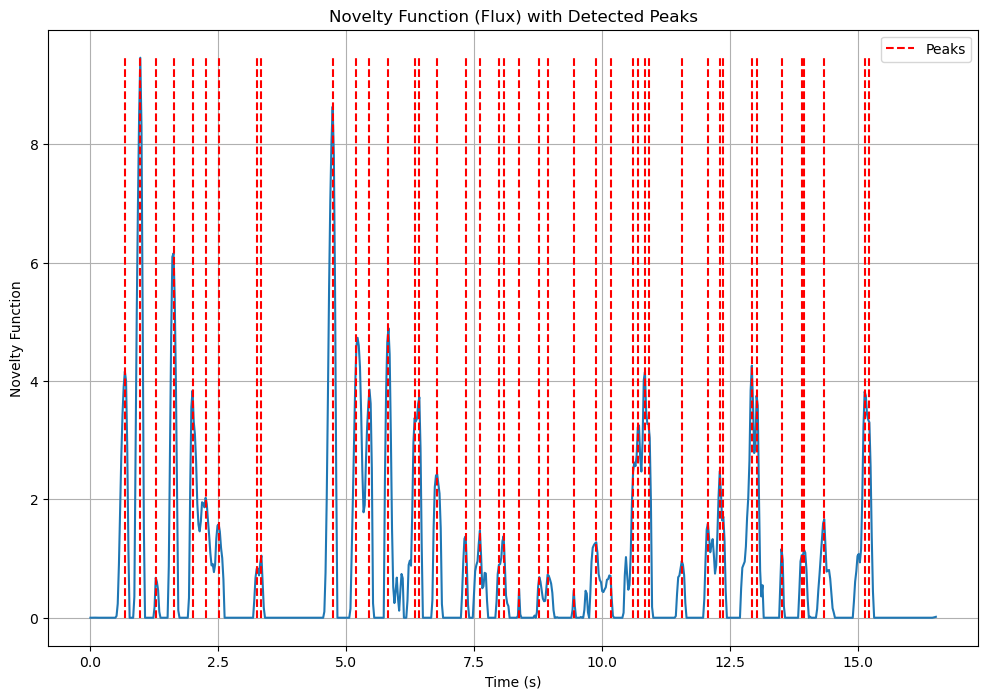

In [ ]:
from utils.visualize import visualizeNoveltyFunction
from pyACA import ToolReadAudio

# Read audio
f_s, wav = ToolReadAudio('asset/pitch/63-M2_AMairena.wav')
d, t, iPeaks = computeEnergyNovelty(wav, frame_size=2048, hop_size=1024)
visualizeNoveltyFunction(d, t, iPeaks)

---
#### STFT-based Novelty Function:
Here, supported novelty function for `STFT-based` in PyACA are: 
-    [`NoveltyFlux`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/NoveltyFlux.py)
-    [`NoveltyHainsworth`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/NoveltyHainsworth.py)
-    [`NoveltyLaroche`](https://github.com/alexanderlerch/pyACA/blob/master/pyACA/NoveltyLaroche.py)

Here is an example:

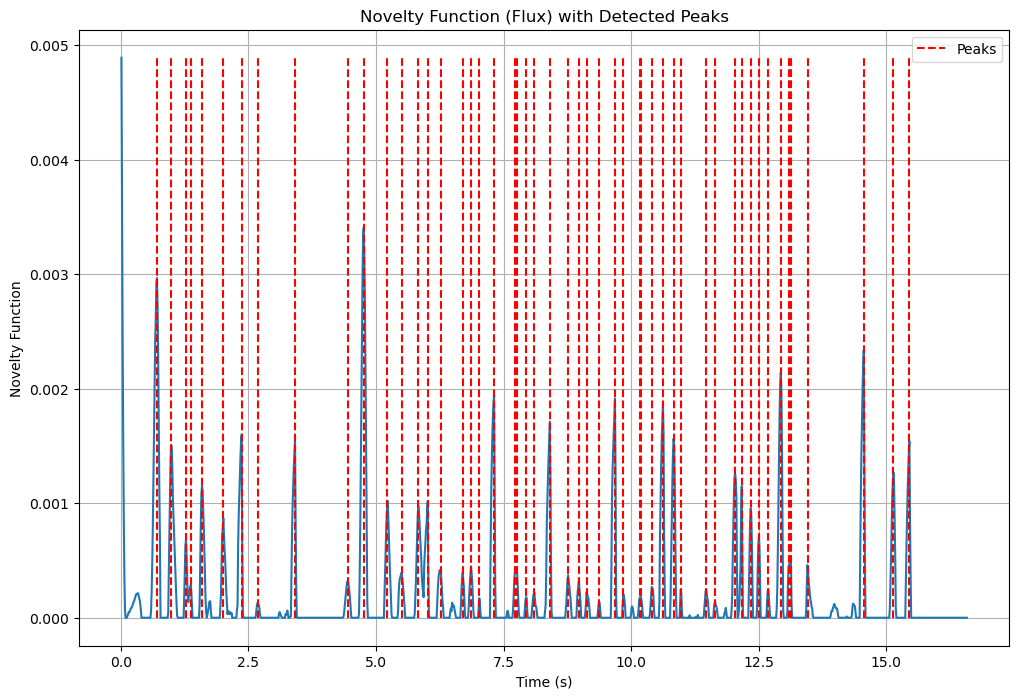

In [10]:
from pyACA import computeNoveltyFunction
from pyACA.ToolPreprocAudio import ToolPreprocAudio
from pyACA.ToolComputeHann import ToolComputeHann
from utils.visualize import visualizeNoveltyFunction
from pyACA import ToolReadAudio

# Settings
iBlockLength = 1024
iHopLength = 512
novelty_func = 'Laroche' # can be 'Hainsworth', 'Laroche'
# Read audio
f_s, wav = ToolReadAudio('asset/pitch/63-M2_AMairena.wav')
# Compute Hann window
afWindow = ToolComputeHann(iBlockLength)
# Preprocess audio (normalize & downmix)
x = ToolPreprocAudio(wav)
# Compute novelty function (using Flux algorithm for example)
[d, t, peaks] = computeNoveltyFunction(novelty_func, x, f_s, afWindow, iBlockLength, iHopLength)
# Visualize novelty function
visualizeNoveltyFunction(d, t, peaks)




---
#### Pitch Domain Novelty Function:

Here, we can simply take the pitch estimation function that used in `PitchContour.ipynb` to compute pitch domain novelty function:

In [45]:
# An example of pitch domain novelty function:
import pyACA

def computePitchNovelty(wav, frame_size, hop_size, f_s):
    pitchAlgo = 'TimeAcf'
    est_freq, t = pyACA.computePitch(pitchAlgo, wav, f_s, iBlockLength=frame_size, iHopLength=hop_size)
    d = np.diff(est_freq, prepend=est_freq[0])
    
    fLenSmoothLpInS = 0.1
    fLenThreshLpInS = 0.14
    iLenSmoothLp = np.max([2, math.ceil(fLenSmoothLpInS * f_s / hop_size)])
    iLenThreshLp = np.max([2, math.ceil(fLenThreshLpInS * f_s / hop_size)])

    b = np.ones(iLenSmoothLp) / iLenSmoothLp
    d = filtfilt(b, 1, d)
    d[d < 0] = 0

    # compute threshold
    iLenThreshLp = min(iLenThreshLp, np.floor(len(d)/3))
    b = np.ones(iLenThreshLp) / iLenThreshLp
    G_T = .6 * np.mean(d[np.arange(1, d.shape[0])]) + filtfilt(b, 1, d)

    # find local maxima above the threshold
    iPeaks = find_peaks(d - G_T, height=0)

    return d, t, iPeaks[0]

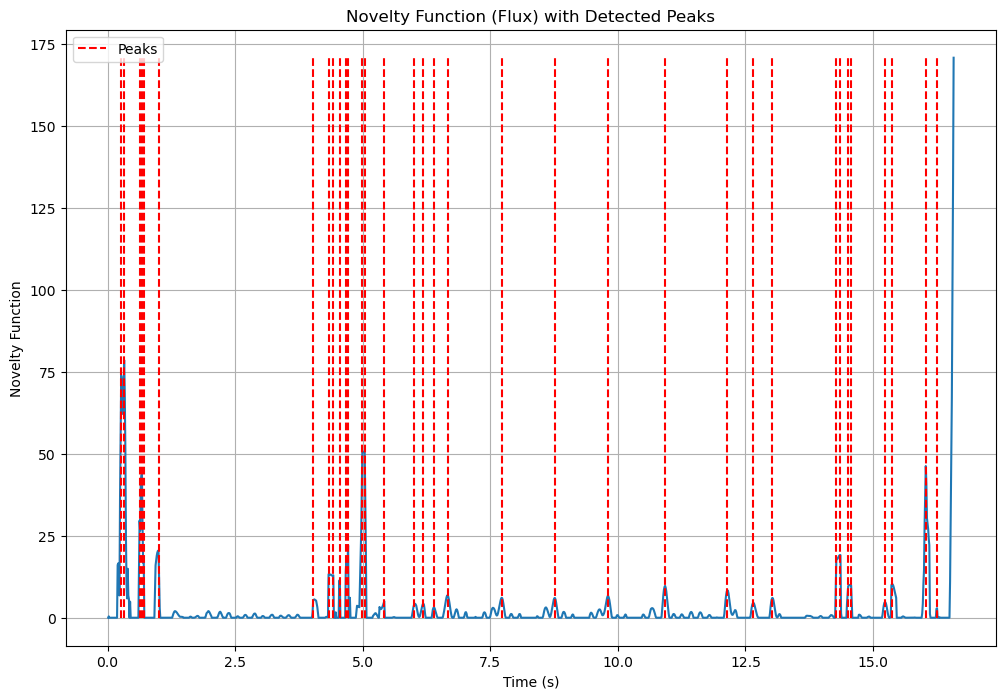

In [44]:

from pyACA import ToolReadAudio

f_s, wav = ToolReadAudio('asset/pitch/63-M2_AMairena.wav')
d, t, iPeaks = computePitchNovelty(wav, 1024, 512, f_s)
visualizeNoveltyFunction(d, t, iPeaks)